In [58]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

## IMPORTING AND SORTING THE DATA

WE HAVE CHOSEN ICECUBE 2008-18 DATA FOR THIS STUDY


THE ICE CUBE DATA SET HAS 1134450 NEUTRINO EVENTS


We select neutrino events with Energy >= 100TeV = 10^5 GeV

i.e log10(E/GeV) > 5


There are 192107 such neutrino events in this data

The ms pulsars are taken from the ATNF Catalogue

There are 441 pulsars (as of May 2022 when the study started)

All the pulsars lie in the declination range of -87 to +87 degrees

In [3]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]

#icdata = icdata.sort_values('log10(E/GeV)')
#icdata = icdata.reset_index()
#icdata = icdata.drop('index', axis=1)
icdata2 = icdata[icdata['log10(E/GeV)'] > 5]
icdata2 = icdata2.reset_index()
icdata2 = icdata2.drop('index', axis=1)
icdata2

#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/10milsecpsr.txt", 'r')
lines = f.readlines()

content=[]
column=lines[3].split()
for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
mspdata = pd.DataFrame(content).drop(range(0,6)).dropna().drop([2,6,8,10,11,13,14], axis=1)
f.close()
line = []
lines = []

mspdata.columns = column
column = []
content=[]
mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
mspdata = mspdata.reset_index()
mspdata = mspdata.drop(["index", "#"], axis=1)

In [4]:
icdata2

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,54562.38662244,5.17,0.62,75.024,-13.371,349.100,76.646
1,54562.39267689,5.57,1.13,305.857,-33.932,120.413,56.090
2,54562.40477593,5.80,1.11,143.516,-38.279,287.171,51.684
3,54562.42794822,5.73,0.53,310.767,-25.374,128.245,64.650
4,54562.43975209,5.38,0.64,147.017,-22.059,296.282,67.903
...,...,...,...,...,...,...,...
192102,58307.86622128,5.05,0.31,283.724,-29.301,44.569,60.727
192103,58307.87487966,5.04,0.24,301.335,-69.169,29.895,20.890
192104,58307.88476760,5.09,0.36,6.179,-68.551,328.904,21.560
192105,58307.92028692,5.23,0.66,17.387,-34.366,330.510,55.740


In [5]:
mspdata

,NAME,Gl,Gb,RAJD,DECJD,P0,F0,DIST
0,J1853-0008g,33.014,-0.453,283.30,-0.13,0.00282,354.609929,4.554
1,J1625-0021,13.890,31.827,246.2931579,-0.358044,0.0028336138772234,352.90623328676,0.951
2,J1852-0044g,32.395,-0.560,283.11,-0.73,0.00241,414.937759,4.492
3,J1835-0114,29.990,3.007,278.841325,-1.242669,0.005116387644239,195.4503977286,3.452
4,J1901-0125,32.817,-2.902,285.39083,-1.42472,0.00279,358.422939,2.360
...,...,...,...,...,...,...,...,...
436,J1944+0907,47.160,-7.357,296.03887491,9.12306353,0.005185201908798642,192.8565208431179,1.218
437,J0023+0923,111.383,-52.849,5.82032291,9.38996121,0.003050203104754390,327.8470205611185,1.818
438,B1855+09,42.290,3.060,284.401626217,9.721442158,0.005362100549682627,186.4940783438289,1.200
439,J2234+0944,76.280,-40.438,338.69522573,9.74172845,0.003627027895734199,275.7078326240928,1.587


In [6]:
max(mspdata['P0'])

'0.0098613486703673'

In [7]:
#icdata2 = nu_10gev(import_icdata())
#mspdata = import_psrdata()
msra = [float(i) for i in mspdata['RAJD']]
msdec = [float(i) for i in mspdata['DECJD']]
icra = [float(i) for i in icdata2['RA[deg]']]
icdec = [float(i) for i in icdata2['Dec[deg]']]
icang = [float(i) for i in icdata2['AngErr[deg]']]
p = len(msra)
lg = len(icra) // p + 1

In [8]:
def hvovec(lon1, lat1, lon2, lat2):

    #Convert decimal degrees to Radians:
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)

    a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))

    return np.abs(np.rad2deg(np.arccos(a)))

In [9]:
msra = [float(i) for i in mspdata['RAJD']]
msdec = [float(i) for i in mspdata['DECJD']]
icra = [float(i) for i in icdata2['RA[deg]']]
icdec = [float(i) for i in icdata2['Dec[deg]']]
icang = [float(i) for i in icdata2['AngErr[deg]']]
p = len(msra)
lg = len(icra) // p + 1

In [10]:
def angfinder(b):
    ang = []
    for a in range(lg):
        
        if a != lg - 1:
        #try:
            ilo = icra[a*p:a*p + p]
            ila = icdec[a*p:a*p + p]
            lo = msra[b] * np.ones(p)
            la = msdec[b] * np.ones(p)
            temp = hvovec(ilo, ila, lo, la)
            for tt in range(len(temp)):
                if temp[tt] > 20:
                    temp[tt] = -1
            ang.extend(temp)
        else:
        #except:
            ilo = icra[a*p:]
            ila = icdec[a*p:]
            ext = len(ilo)
            lo = msra[b] * np.ones(ext)
            la = msdec[b] * np.ones(ext)
            temp = hvovec(ilo, ila, lo, la)
            #ang.extend(hvovec(ilo, ila, lo, la))
            for tt in range(len(temp)):
                if temp[tt] > 20:
                    temp[tt] = -1
            ang.extend(temp)
            
        
    return ang

pool = mul.Pool()
op_async = pool.map_async(angfinder, range(0,p))
aang = op_async.get()
op_async = []
pool = []

In [10]:
def n_ij(i):
    arr = []
    for j in range(0,len(icdata2)):
        
        ang = aang[i][j]

        if ang != -1:
            if ang < 20:
                arr.append([msra[i], msdec[i], icra[j], icdec[j], icang[j], ang])
    return arr

def nn():
    pool = mul.Pool()
    op_async = pool.map_async(n_ij, range(0,p))
    si = op_async.get()
    pool = []
    op_async = []
    return si

nnearp = nn()

In [ ]:
os.getcwd()

In [11]:
f = open('nnearp.txt', 'w')
f.write('msra, msdec, nura, nudec, angerr, angwithpulsar\n')
for i in nnearp:
    for j in i:
        f.write(str(j).replace('[', '').replace(']', '') + '\n')
f.close()
nnearp = []

we only select those neutrino events, whose angular distance  is within $20^{\circ}$ of a MSP.  For a dataset of $N$ events, if $n_s$ signal events are attributed to a millisecond pulsar, the probability density of an individual event $i$ is given by:
\begin{equation}
P_i = \frac{n_s}{N} S_i + (1-\frac{n_s}{N}) B_i,
%\label{eq1}
\end{equation}
where $S_i$ and $B_i$ represent the signal and background pdfs, respectively.
The likelihood function ($\mathcal{L}$) of the entire dataset, obtained from the product of each individual PDF can be written as 
\begin{equation}
\mathcal{L} (n_s) = \prod_{i=1}^N P_i,
\end{equation}
where $P_i$ is the same as in eq1 above. The signal PDF is given by:
\begin{equation}
\large
S_i = \frac{1}{2\pi\sigma_i^2}e^{\frac{-(|\theta_i-\theta_s|)^2}{2\sigma_i^2}}
\end{equation}
where $|\theta_i-\theta_s|$ is the angular distance between the  MSP and the neutrino, whereas $\sigma_i$ is the angular uncertainty in the neutrino position.
The background PDF is determined from the average number of events per solid angle  within a declination of $\pm 3^{\circ}$ after averaging over RA. We do not incorporate  the energy information, since the pubic IceCube catalog only contains the energy of the reconstructed muon. The detection statistic used to ascertain the presence of a signal is given by:
\begin{equation}
TS (n_s) = 2 \log \frac{\mathcal{L} (n_s)}{\mathcal{L} (0)}
\end{equation}
 If the null hypothesis is true, $TS (n_s)$ obeys the $\chi^2$ distribution for one degree of freedom. We calculated $TS (n_s)$ for all MSPs in the  catalog.

### FOR $\nu_i$ and $p_j$ and  N = len(icdata2) = Total no.of $\nu$ samples
### ns[i] = no.of $\nu$ events with angles $<= 20 \deg$ with $psr_i$
### $S_i = \frac{1}{2\pi\sigma_i^2}e^{\frac{-(|\theta_i-\theta_s|)^2}{2\sigma_i^2}}$
### $|\theta_i-\theta_s|$ = aang[i][s]
### $\sigma_i$ = icang[i]           and                  sg =      $\sigma_i^2$
###

N = len(icdata2)

ns = []
for i in aang:
    count = 0
    for j in i:
        if j != -1:
            count += 1
    ns.append(count)
ns = np.array(ns)
    

Ns = np.sum(ns)//2

In [11]:
N = len(icdata2)

In [12]:

#S_ij for ith neutrino and jth pulsar IS WRONG
#EDIT 04102022 - 11.28 - S_ij is for i^th pulsar and j^th neutrino and summed over all NEUTRINOS
def S_ij(i):
    arr = []
    
    for j in range(0,len(icdata2)):
        
        ang = aang[i][j]
        if ang != -1:
            if ang < 20:
                sg = np.deg2rad(icang[j]) ** 2
                ang = np.deg2rad(ang) ** 2
                arr.append(np.exp(-1 * ang / (2 * sg)) / (2 * np.pi * sg))
        #return
        else:
            arr.append(0)
        #return -1
    
    return np.sum(arr)

'''
def S_ij(i):
    arr = []
    
    for j in range(0,len(icdata2)):
        
        ang = aang[i][j]
        if ang != -1:
            if ang < 20:
                sg = np.deg2rad(icang[j]) ** 2
                ang = np.deg2rad(ang) ** 2
                arr.append(np.deg2rad(icra[j]) * np.exp(-ang / (2 * sg)) / (2 * np.pi * sg))
        #return
        else:
            arr.append(0)
        #return -1
    
    return np.sum(arr)/np.deg2rad(np.sum(icra))
'''
def sij():
    pool = mul.Pool()
    op_async = pool.map_async(S_ij, range(0,p))
    si = op_async.get()
    pool = []
    op_async = []
    return si
#for i in range(len(si)):

#S = Si()

### S stores $S_i$ values for all pulsars

In [34]:
S = np.array(sij()) 

2103.12813

For each sample, given the Dec δi of an event, the background PDF is determined by the relative number of
events in δi ± $3^◦$ divided by the solid angle.

so calculate total no of events within delta +/- 3
and then divide by 2 pi (sin[delta+3]-sin[delta-3])

you can choose all events
withiin delta +/- 3


In [35]:
def bg(i):
    #Calculating total no of neutrino events within delta +/- 6 of ith PULSAR (not neutrino)
    count = 0
    
    '''for j in icdec:
        if abs(msdec[i] - j) <= 6:
            count+=1 '''
    count = np.count_nonzero(np.abs(np.subtract(msdec[i],icdec))<6)
    #calculating solid angle with 3deg
    sang = 2 * np.pi * (np.sin(np.deg2rad(msdec[i] + 6)) - np.sin(np.deg2rad(msdec[i] - 6)))
    return count/sang

def Bi():
    pool = mul.Pool()
    op_async = pool.map_async(bg, range(0,p))
    return op_async.get()

B = np.array(Bi())

### B stores $B_i$ values for all pulsars

In [36]:
for i in range(len(S)):
    if S[i] == max(S):
        print(i)

176


In [37]:
max(S)

81013.82532461955

In [38]:
min(S)

1.6047852132712384e-301

In [39]:
max(B)

49943.391196415156

In [40]:
min(B)

1.1695157219219698

### For $a^{th}$ pulsar

### $P_i[a] = \dfrac{ns[a]}{N} S[a] + \left(1 - \dfrac{ns[a]}{N}\right)B[a]$ if ns = no.of $\nu$ events with angles $<= 20 \deg$ with $psr_a$

                                                 OR
                                                 
### $P_i[a] = \dfrac{ns}{N} S[a] + \left(1 - \dfrac{ns}{N}\right)B[a]$     where ns is a scalar number specified manually in
### $\mathcal{L}(ns) = np.product(P_i(ns, N, S, B))$

In [41]:
'''
import numpy as np
import matplotlib.pylab as plt
from math import pi
from scipy.optimize import minimize
data=np.genfromtxt("nnearp.txt", delimiter=',',names=True)


nura=data['nura'] #neutrino RA
nudec=data['nudec'] #neutrino DEC
angerr=data['angerr'] # error in neutrino position
ra=283.3 #pulsar RA
dec=-0.13 # pulsar DEC
cang=np.sin(dec*pi/180.0)*np.sin(nudec*pi/180.0)+ np.cos(dec*pi/180.0)*np.cos(nudec*pi/180.0)*np.cos((ra-nura)*pi/180.0) 
ang=(180.0/pi)*np.arccos(cang) # angle between pulsar and neutrino in degrees
angerrrad=angerr*pi/180.0 # angle between pulsar and neutrino in radins
N=len(nura) # total no of neutrinos  used for analysis
bkgct=np.count_nonzero(np.abs(nudec-dec)<3) # total no of bkgd neutrinos within 3 degrees
Bi=bkgct/(2*pi*(np.sin((180.0/pi)*(dec+3))- np.sin((180.0/pi)*(dec-3))))
Si=np.exp(-0.5*(ang/angerr)**2)/(2*pi*angerrrad*angerrrad)


# the function rtruns TS(ns) in Zhou paper
def L(x):
    TS=np.log(x*Si/N+(1-x/N)*Bi)-np.log(Bi)
    return 2*np.sum(TS)

# since scipy.optimize can only do minization calculate negative of L(x) to maximize L(x)
nll = lambda x: -L(x)
soln = minimize(nll, 3,bounds=((0,None),)) # to ensure that ns is > 0
ns=soln.x
print ns
print L(ns)
'''

'\nimport numpy as np\nimport matplotlib.pylab as plt\nfrom math import pi\nfrom scipy.optimize import minimize\ndata=np.genfromtxt("nnearp.txt", delimiter=\',\',names=True)\n\n\nnura=data[\'nura\'] #neutrino RA\nnudec=data[\'nudec\'] #neutrino DEC\nangerr=data[\'angerr\'] # error in neutrino position\nra=283.3 #pulsar RA\ndec=-0.13 # pulsar DEC\ncang=np.sin(dec*pi/180.0)*np.sin(nudec*pi/180.0)+ np.cos(dec*pi/180.0)*np.cos(nudec*pi/180.0)*np.cos((ra-nura)*pi/180.0) \nang=(180.0/pi)*np.arccos(cang) # angle between pulsar and neutrino in degrees\nangerrrad=angerr*pi/180.0 # angle between pulsar and neutrino in radins\nN=len(nura) # total no of neutrinos  used for analysis\nbkgct=np.count_nonzero(np.abs(nudec-dec)<3) # total no of bkgd neutrinos within 3 degrees\nBi=bkgct/(2*pi*(np.sin((180.0/pi)*(dec+3))- np.sin((180.0/pi)*(dec-3))))\nSi=np.exp(-0.5*(ang/angerr)**2)/(2*pi*angerrrad*angerrrad)\n\n\n# the function rtruns TS(ns) in Zhou paper\ndef L(x):\n    TS=np.log(x*Si/N+(1-x/N)*Bi)-np.

In [42]:
for i in range(p):
    if B[i] == 0:
        print(i)

In [43]:
#RETURNS ALL THE PROBABILITIES FOR

def Pr(ns, N, S, B):
    nsN = ns/N
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))

In [123]:
s0 = S_ij(1)
s0

11.270475418130244

In [125]:
b0 = bg(1)
b0

101.25481653481943

In [128]:
p00 = Pr(0, N, s0, b0)
a = []
for i in range(1000):
    a.append(Pr(i, N, s0, b0)/p00)

a.index(max(a))
#p02 = Pr(2, N, s0, b0)
#p02/p00

0

In [127]:
N = len(icdata2)
l = Pr(0, N, S, B)
l2 = Pr(2, N, S, B)

In [49]:
max(l2/l)

1.001310586242036

In [50]:
for i in range(len(l2)):
    if l2[i] == max(l2):
        print(i)

185


In [54]:
l2[0]/l[0]

0.9999972153354053

In [53]:
l2[185]

49943.3811361116

In [29]:
arr = l2/l

In [30]:
np.prod(arr)

0.9579886548674186

In [31]:
def Ls(ns1, N,S, B):
    return np.prod(Pr(ns1, N,S, B))

def L_n(S, B, N, ns):
    L = np.ones(len(ns))
    for i in range(0, len(l)):
        for j in range(len(l[i])):
            L[i] *= l[i][j]
    return L
L = L_n(S, B, N, ns)


In [97]:
def TS(lt, S, B, N):
    ts =2 * np.log(np.product(Pr(i, N, S, B)/Pr(0, N, S, B)))
    return ts
ts = TS(1000, S, B, N)

In [115]:
def TSmax(i):
    #returns the TSmax for i^th GRB
    a = []
    for j in range(1000):
        a.append(-TS(j, S[i], B[i], N))
         
    init_guess = a.index(max(a))
    nll = lambda x: -TS(x, S[i], B[i], N)
    soln = minimize(nll, 3 ,bounds=((0,None),))
    ns = float(soln.x)
    return ns

ns = []
for i in range(p):
    ns.append(TSmax(i))

def TSmax(i):
    #returns the TSmax for i^th GRB
    nll = lambda x: -TS(x, S[i], B[i], N)
    a = []
    for j in range(1000):
        a.append(nll(j))
         
    init_guess = a.index(min(a))
    soln = minimize(nll, init_guess, bounds=((0,None),))
    ns = float(soln.x)
    return ns

NS = []
for i in range(p):
    NS.append(TSmax(i))

In [116]:
ns

[3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0

In [117]:
tns = np.array([TS(ns[i], S[i], B[i], N) for i in range(p)])

In [118]:
np.count_nonzero(ns != 3)

1

In [119]:
tns

array([-1.22562789e-03, -4.07505148e-03, -1.81125779e-03, -2.33119041e-03,
       -4.03851472e-03, -2.29300351e-03, -2.51551602e-03, -2.16563545e-03,
       -1.40802835e-03,  1.05873724e-03, -1.03443136e-03, -8.05649420e-05,
        5.47043243e-05,  6.20772729e-05,  1.15412162e-03,  2.42935539e-03,
       -1.19587005e-03, -7.69461783e-04, -1.40761381e-03,  3.82413606e-04,
        2.04656214e-04, -6.61431148e-04,  1.36469710e-04,  4.81682299e-05,
        1.28232450e-03, -6.69676929e-04, -4.32837600e-03, -4.19698175e-05,
       -4.41781916e-05,  1.55528391e-03, -9.44295593e-05,  4.39369740e-04,
       -1.17281537e-04, -1.59913618e-03,  1.72427899e-03, -1.74794900e-03,
       -1.47731180e-03, -1.08319333e-03, -1.07951699e-03, -1.55720735e-03,
       -5.77523757e-05,  7.40423569e-04,  7.99673368e-04,  7.89477908e-04,
        7.70767129e-04,  7.99622466e-04,  7.79997206e-04,  7.79997206e-04,
        7.79997206e-04,  7.79997206e-04,  7.79997206e-04,  7.79997206e-04,
        7.79997206e-04,  

In [34]:
np.array(ts)
ts

[0.0,
 0.00010778678218173449,
 0.0002151709231102049,
 0.0003221529175184356,
 0.0004287332591690776,
 0.0005349124408603479,
 0.0006406909544369706,
 0.0007460692908234544,
 0.000851047939943277,
 0.0009556273908090041,
 0.0010598081314667097,
 0.0011635906490532956,
 0.001266975429732632,
 0.001369962958743803,
 0.0014725537203809655,
 0.0015747481980382821,
 0.0016765468741524131,
 0.0017779502302185646,
 0.001878958746844046,
 0.001979572903696916,
 0.0020797931795212225,
 0.002179620052139729,
 0.00227905399845932,
 0.0023780954945046744,
 0.0024767450153482477,
 0.0025750030351997127,
 0.0026728700272790193,
 0.0027703464639698455,
 0.0028674328167568666,
 0.0029641295562138023,
 0.003060437152009154,
 0.0031563560729075068,
 0.0032518867868150175,
 0.003347029760714593,
 0.0034417854607182823,
 0.003536154352050485,
 0.0036301368990486315,
 0.003723733565163872,
 0.0038169448129869044,
 0.003909771104219248,
 0.004002212899686972,
 0.0040942706593422975,
 0.004185944842281907,


We use the same unbinned likelihood method as in ~\cite{Hooper,Kamionkowski,LuoZhang} which was first proposed in ~\cite{Montaruli10}. Similar to ~\cite{LuoZhang}, we only select those neutrino events, whose angular distance  is within $20^{\circ}$ of a MSP.  For a dataset of $N$ events, if $n_s$ signal events are attributed to a millisecond pulsar, the probability density of an individual event $i$ is given by:
\begin{equation}
P_i = \frac{n_s}{N} S_i + (1-\frac{n_s}{N}) B_i,
%\label{eq1}
\end{equation}
where $S_i$ and $B_i$ represent the signal and background pdfs, respectively.
The likelihood function ($\mathcal{L}$) of the entire dataset, obtained from the product of each individual PDF can be written as 
\begin{equation}
\mathcal{L} (n_s) = \prod_{i=1}^N P_i,
\end{equation}
where $P_i$ is the same as in Eq.~\ref{eq1}. The signal PDF is given by
\begin{equation}
S_i = \frac{1}{2\pi\sigma_i^2}e^{-(|\theta_i-\theta_s|)^2/2\sigma_i^2}
\end{equation}
where $|\theta_i-\theta_s|$ is the angular distance between the  MSP and the neutrino, whereas $\sigma_i$ is the angular uncertainty in the neutrino position.
The background PDF is determined from the average number of events per solid angle  within a declination of $\pm 3^{\circ}$ after averaging over RA. We do not incorporate  the energy information, since the pubic IceCube catalog only contains the energy of the reconstructed muon. The detection statistic used to ascertain the presence of a signal is given by:
\begin{equation}
TS (n_s) = 2 \log \frac{\mathcal{L} (n_s)}{\mathcal{L} (0)}
\end{equation}
 If the null hypothesis is true, $TS (n_s)$ obeys the $\chi^2$ distribution for one degree of freedom. We calculated $TS (n_s)$ for all MSPs in the  catalog.

In [131]:
def Ls(ns1, N,S, B):
    return np.prod(Pr(ns1, N,S, B))

In [144]:
def TS(ns, S, B, N):
    ts = []
    for i in ns:
        temp = []
        for j in range(p):
            
            temp.append(2 * np.log10(Ls(i, N, S[j], B[j])/Ls(0, N, S[j], B[j])))
        ts.append(temp)
    return ts
ts = TS(ns, S, B, N)

In [143]:
ts[0]

-3.6281009797577323e-06

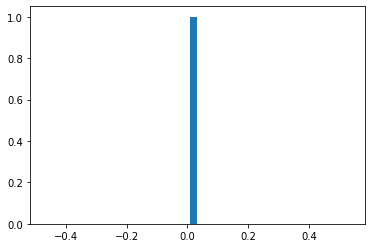

In [129]:
plt.figure()
plt.hist(ts, 40)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (1000,)

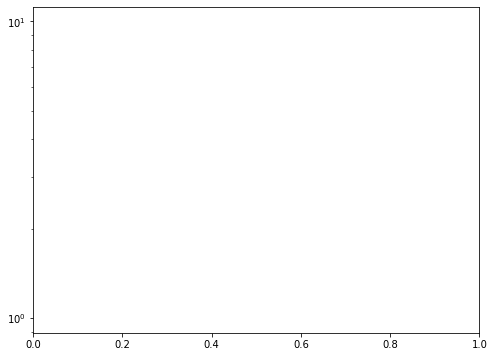

In [130]:
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.plot( ts,range(0, 1000))
plt.show()